# Assessing Wikipedia Bias

## 1. You will need to collect data from a source of your choosing (dataset, wikipedia API, web-scraping)

## Introduction

The project

## Data Overview

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import random

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder


from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


from wordcloud import WordCloud

import xgboost as xgb
from textblob import TextBlob

from sklearn.model_selection import GridSearchCV

from tqdm import tqdm


In [2]:
# Load the datasets
data = pd.read_csv('final_labels.csv', sep=';')

# Display the first few rows of the dataset
display(data.head())

,text,news_link,outlet,topic,type,label_bias,label_opinion,biased_words
0,"""Orange Is the New Black"" star Yael Stone is r...",https://www.foxnews.com/entertainment/australi...,Fox News,environment,right,Non-biased,Entirely factual,[]
1,"""We have one beautiful law,"" Trump recently sa...",https://www.alternet.org/2020/06/law-and-order...,Alternet,gun control,left,Biased,Somewhat factual but also opinionated,"['bizarre', 'characteristically']"
2,"...immigrants as criminals and eugenics, all o...",https://www.nbcnews.com/news/latino/after-step...,MSNBC,white-nationalism,left,Biased,Expresses writer’s opinion,"['criminals', 'fringe', 'extreme']"
3,...we sounded the alarm in the early months of...,https://www.alternet.org/2019/07/fox-news-has-...,Alternet,white-nationalism,left,Biased,Somewhat factual but also opinionated,[]
4,[Black Lives Matter] is essentially a non-fals...,http://feedproxy.google.com/~r/breitbart/~3/-v...,Breitbart,marriage-equality,NaN,Biased,Expresses writer’s opinion,['cult']


### Data preprocessing

In [3]:
# Display the column names of the dataset
column_names = data.columns.tolist()
display(column_names)

['text',
 'news_link',
 'outlet',
 'topic',
 'type',
 'label_bias',
 'label_opinion',
 'biased_words']

In [4]:
# Display the shape of the dataset
n_rows, n_cols = data.shape
print(f"The DataFrame has {n_rows} rows and {n_cols} columns")

The DataFrame has 3674 rows and 8 columns


In [5]:
# Display the informative summary of the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3674 entries, 0 to 3673
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           3674 non-null   object
 1   news_link      3642 non-null   object
 2   outlet         3674 non-null   object
 3   topic          3674 non-null   object
 4   type           2674 non-null   object
 5   label_bias     3674 non-null   object
 6   label_opinion  3674 non-null   object
 7   biased_words   3674 non-null   object
dtypes: object(8)
memory usage: 229.8+ KB


In [6]:
# Display the descriptive statistics of the dataset

data.describe()

,text,news_link,outlet,topic,type,label_bias,label_opinion,biased_words
count,3674,3642,3674,3674,2674,3674,3674,3674
unique,3674,2095,11,23,3,3,4,1623
top,"""Orange Is the New Black"" star Yael Stone is r...",http://feedproxy.google.com/~r/breitbart/~3/MB...,Breitbart,marriage-equality,right,Non-biased,Entirely factual,[]
freq,1,15,943,347,993,1863,1600,1825


## 2. You will conduct EDA that you see fit to appropriately investigate text of wikipedia articles you look to predict on for biased terms, sentiment, or other linguistic significance.

## Explorating Data Analysis

### Duplicates

In [7]:
# Display the number of duplicates in the dataset
duplicates = data[data.duplicated()]
display(f"Number of duplicated data: {duplicates.shape[0]}")

'Number of duplicated data: 0'

### Missing Values

In [8]:
# Display the number of missing values in the dataset
display(data.isna().sum())

# Check for missing values in the DataFrame as a percentage
display(data.isna().sum()/len(data)) 

text                0
news_link          32
outlet              0
topic               0
type             1000
label_bias          0
label_opinion       0
biased_words        0
dtype: int64

text             0.000000
news_link        0.008710
outlet           0.000000
topic            0.000000
type             0.272183
label_bias       0.000000
label_opinion    0.000000
biased_words     0.000000
dtype: float64

In [9]:
# Drop rows with missing values in the 'news_link' and 'article' columns
data.dropna(subset=['news_link'], inplace=True)
data.dropna(subset=['type'], inplace=True)

In [10]:
# Check for missing values in the DataFrame as a percentage
display(data.isna().sum()/len(data)) 

text             0.0
news_link        0.0
outlet           0.0
topic            0.0
type             0.0
label_bias       0.0
label_opinion    0.0
biased_words     0.0
dtype: float64

In [11]:
# Cleaning the text data in the 'text' column
# Define a function to clean the text data 
def clear_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-z\s]","", text)
    text = text.split()
    return " ".join(text)

In [12]:
data['label_bias'] = data['label_bias'].str.lower()

In [13]:
# Apply the clear_text function to the 'comment_text' column
data['clean_text'] = data['text'].astype(str).apply(clear_text) 
data= data.drop(columns=['text'])

# Display the first 5 rows of the comments DataFrame after cleaning
display(data.sample(5)) 


,news_link,outlet,topic,type,label_bias,label_opinion,biased_words,clean_text
2306,https://feeds.feedblitz.com/~/593581096/0/alte...,Alternet,middle-class,left,biased,Expresses writer’s opinion,['flippancy'],sen ernsts flippancy shows how little she and ...
3223,https://www.alternet.org/2020/07/supreme-court...,Alternet,taxes,left,biased,Somewhat factual but also opinionated,"['claiming', 'aggressively']",trump and his attorneys have been aggressively...
1166,http://feedproxy.google.com/~r/breitbart/~3/Lx...,Breitbart,taxes,right,biased,Somewhat factual but also opinionated,['claimed'],he recently released a social media ad featuri...
2954,https://www.reuters.com/article/us-usa-healthc...,Reuters,universal health care,center,biased,Somewhat factual but also opinionated,['scrapped'],the trump administration on thursday scrapped ...
1326,https://www.reuters.com/article/us-usa-electio...,Reuters,gun-control,center,non-biased,Entirely factual,[],in addition to more background checks biden ad...


In [14]:
# Check for missing values
print(data['clean_text'].isna().sum())  

0


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2644 entries, 0 to 3673
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   news_link      2644 non-null   object
 1   outlet         2644 non-null   object
 2   topic          2644 non-null   object
 3   type           2644 non-null   object
 4   label_bias     2644 non-null   object
 5   label_opinion  2644 non-null   object
 6   biased_words   2644 non-null   object
 7   clean_text     2644 non-null   object
dtypes: object(8)
memory usage: 185.9+ KB


In [16]:
## Set of English stop words
stop_words =  set(stopwords.words('english')) 

In [17]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer() 

def lemmatize(text):
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token not in stop_words]
    lemmas = [lemmatizer.lemmatize(token) for token in tokens]
    return " ".join(lemmas)

In [18]:
# Apply the clear_text function to the 'comment_text' column
data['lemmatize_text'] = data['clean_text'].apply(lemmatize) 

In [19]:
# Display the first 5 rows of the comments DataFrame after cleaning
display(data[['clean_text', 'lemmatize_text']].head(20))

,clean_text,lemmatize_text
0,orange is the new black star yael stone is ren...,orange new black star yael stone renouncing u ...
1,we have one beautiful law trump recently said ...,one beautiful law trump recently said characte...
2,immigrants as criminals and eugenics all of wh...,immigrant criminal eugenics considered fringe ...
3,we sounded the alarm in the early months of tr...,sounded alarm early month trump presidency pri...
9,a new low washington post media critic blows u...,new low washington post medium critic blow tuc...
10,gangster capitalist trump is running a mafia s...,gangster capitalist trump running mafia state ...
11,the most progressive president since fdr biden...,progressive president since fdr bidens policy ...
18,the goal is to send a message of peace the yea...,goal send message peace yearold claimed insist...
20,you know theres over million people with preex...,know there million people preexisting conditio...
21,people were arrested for offences including as...,people arrested offence including assaulting p...


In [20]:
data.shape

(2644, 9)

In [21]:
data.columns

Index(['news_link', 'outlet', 'topic', 'type', 'label_bias', 'label_opinion',
       'biased_words', 'clean_text', 'lemmatize_text'],
      dtype='object')

In [22]:
data['is_biased'] = data['label_bias'].apply(lambda x: 1 if x == 'biased' else 0)


In [23]:
data.head()

,news_link,outlet,topic,type,label_bias,label_opinion,biased_words,clean_text,lemmatize_text,is_biased
0,https://www.foxnews.com/entertainment/australi...,Fox News,environment,right,non-biased,Entirely factual,[],orange is the new black star yael stone is ren...,orange new black star yael stone renouncing u ...,0
1,https://www.alternet.org/2020/06/law-and-order...,Alternet,gun control,left,biased,Somewhat factual but also opinionated,"['bizarre', 'characteristically']",we have one beautiful law trump recently said ...,one beautiful law trump recently said characte...,1
2,https://www.nbcnews.com/news/latino/after-step...,MSNBC,white-nationalism,left,biased,Expresses writer’s opinion,"['criminals', 'fringe', 'extreme']",immigrants as criminals and eugenics all of wh...,immigrant criminal eugenics considered fringe ...,1
3,https://www.alternet.org/2019/07/fox-news-has-...,Alternet,white-nationalism,left,biased,Somewhat factual but also opinionated,[],we sounded the alarm in the early months of tr...,sounded alarm early month trump presidency pri...,1
9,https://www.alternet.org/2019/08/a-new-low-was...,Alternet,white-nationalism,left,biased,Expresses writer’s opinion,"['blows', 'up', 'absurd', 'lies', 'nationalism...",a new low washington post media critic blows u...,new low washington post medium critic blow tuc...,1


In [24]:
data.shape

(2644, 10)

In [25]:
data.columns

Index(['news_link', 'outlet', 'topic', 'type', 'label_bias', 'label_opinion',
       'biased_words', 'clean_text', 'lemmatize_text', 'is_biased'],
      dtype='object')

### Data Analysis

#### Which words are most frequently flagged as biased across the dataset?

#### How does sentiment differ between biased and unbiased texts?

#### What proportion of an article's sentences are labeled as biased or opinionated?

#### Which news outlet have the highest average bias score?



#### Which topics have the most biased words on average per article?



#### Do specific outlet use biased terms more frequently on certain topics?

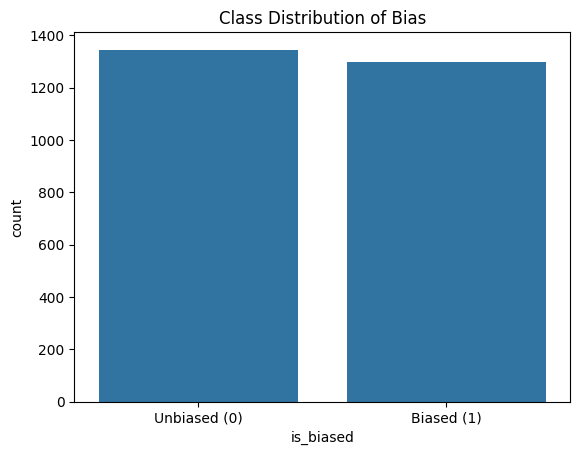

In [26]:
sns.countplot(x='is_biased', data=data)
plt.title('Class Distribution of Bias')
plt.xticks([0,1], ['Unbiased (0)', 'Biased (1)'])
plt.show()

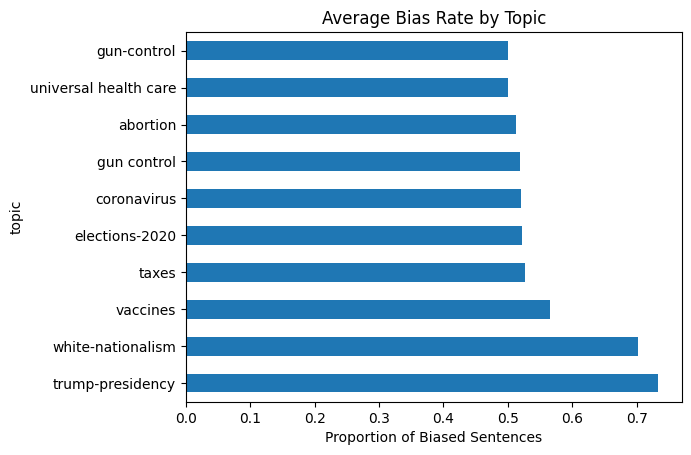

In [27]:
bias_by_topic = data.groupby('topic')['is_biased'].mean().sort_values(ascending=False).head(10)
bias_by_topic.plot(kind='barh')
plt.title('Average Bias Rate by Topic')
plt.xlabel('Proportion of Biased Sentences')
plt.show()

## 3. You will conduct supervised learning to be able to predict if a given text is biased. You might want to be able to do this on the sentence by sentence level.

In [28]:
data.columns

Index(['news_link', 'outlet', 'topic', 'type', 'label_bias', 'label_opinion',
       'biased_words', 'clean_text', 'lemmatize_text', 'is_biased'],
      dtype='object')

In [29]:
data['is_biased'].value_counts()

is_biased
0    1345
1    1299
Name: count, dtype: int64

### Class distribution

### TF-IDF & Logistic Regression:

In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    data['lemmatize_text'], data['is_biased'], test_size=0.2, random_state=42
)

In [ ]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


In [36]:
X_train.shape

(2115,)

In [37]:
X_train_vec.shape

(2115, 5000)

In [38]:
y_train.shape

(2115,)

In [39]:
model = LogisticRegression()
model.fit(X_train_vec, y_train)

y_pred = model.predict(X_test_vec)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.722117202268431
[[199  65]
 [ 82 183]]
              precision    recall  f1-score   support

           0       0.71      0.75      0.73       264
           1       0.74      0.69      0.71       265

    accuracy                           0.72       529
   macro avg       0.72      0.72      0.72       529
weighted avg       0.72      0.72      0.72       529



In [41]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

In [ ]:
model_rf = RandomForestClassifier(random_state=7)

grid_search = GridSearchCV(
    estimator=model_rf,
    param_grid=param_grid,
    cv=5,  
    scoring='f1',  
    verbose=2,
)

grid_search.fit(X_train_vec, y_train)

print("Best Parameters:", grid_search.best_params_)

best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test_vec)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END max_dep

In [44]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.6937618147448015
[[188  76]
 [ 86 179]]
              precision    recall  f1-score   support

           0       0.69      0.71      0.70       264
           1       0.70      0.68      0.69       265

    accuracy                           0.69       529
   macro avg       0.69      0.69      0.69       529
weighted avg       0.69      0.69      0.69       529



In [61]:
param_grid = {
    'n_estimators': [50, 100,],  
    'learning_rate': [0.01, 0.05, 0.1],  
    'max_depth': [3, 4, 5], 
    'subsample': [0.7, 0.8, 1.0], 
    'colsample_bytree': [0.7, 0.8, 1.0],  
    'scale_pos_weight': [1, 2, 3],  
}

In [62]:
model_xg = XGBClassifier(eval_metric='logloss')

grid_search = GridSearchCV(estimator=model_xg, param_grid=param_grid, 
                           scoring='f1', cv=3, verbose=1, n_jobs=-1)

grid_search.fit(X_train_vec, y_train)

print("Best Hyperparameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_vec)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 486 candidates, totalling 1458 fits
Best Hyperparameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'scale_pos_weight': 2, 'subsample': 0.7}
Accuracy: 0.6521739130434783
[[108 156]
 [ 28 237]]
              precision    recall  f1-score   support

           0       0.79      0.41      0.54       264
           1       0.60      0.89      0.72       265

    accuracy                           0.65       529
   macro avg       0.70      0.65      0.63       529
weighted avg       0.70      0.65      0.63       529



In [54]:
param_grid = {
    'num_leaves': [15, 31, 63],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100],
    'max_depth': [-1, 10, 20],
}

In [57]:
model_lg = LGBMClassifier(eval_metric='logloss')

grid_search = GridSearchCV(estimator=model_lg, param_grid=param_grid, 
                           scoring='f1', cv=3, verbose=1)

grid_search.fit(X_train_vec, y_train)

print("Best Hyperparameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_vec)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 690, number of negative: 720
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006205 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6711
[LightGBM] [Info] Number of data points in the train set: 1410, number of used features: 259
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.489362 -> initscore=-0.042560
[LightGBM] [Info] Start training from score -0.042560
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 689, number of negative: 721
[LightGBM] [Info] Auto-choosing col-wise multi-threading, 

In [56]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.665406427221172
[[176  88]
 [ 89 176]]
              precision    recall  f1-score   support

           0       0.66      0.67      0.67       264
           1       0.67      0.66      0.67       265

    accuracy                           0.67       529
   macro avg       0.67      0.67      0.67       529
weighted avg       0.67      0.67      0.67       529



## 4. You need to have a prediction function that can take in a new wikipedia article and predict how biased it is. You can do this by predicting if each sentence in an article is biased, then perhaps scaling the results by the length of the article to get somewhat of a“bias score”

In [33]:
# def get_sentiment(text):
#    return TextBlob(text).sentiment.polarity

#data['biased_score'] = data['clean_text'].apply(get_sentiment)
#data['biased_label'] = data['biased_score'].apply(lambda x: 'biased' if x > 0 else 'unbiased')